In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [4]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/coastal_protection_output_data/"

In [5]:
countrydata = pd.read_csv(myfolder+"country_output.csv")

In [5]:
checkdata = pd.read_csv(myfolder+"region_output_WB_cumulative.csv")

In [6]:
originaldata = pd.read_csv(myfolder+"region_output_WB.csv")

In [6]:
countrydata.columns

Index(['locationid', 'locationname', 'rcp', 'ada', 'ssp', 'adacost',
       'riverprotection', 'time', 'rslr', 'par', 'pop_below_h100',
       'riverdike_cost', 'riverdike_maintenance_cost', 'seadike_cost',
       'seadike_maintenance_cost', 'seafloodcost', 'surge_barrier_cost',
       'surge_barrier_maintenance_cost', 'protection_investment_cost',
       'protection_maintenance_cost', 'gdp'],
      dtype='object')

In [7]:
countrydata.time.unique()

array([2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060,
       2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

In [43]:
mydata = countrydata.copy()

In [23]:
inter = mydata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])["protection_investment_cost"].unstack("time").reset_index()

In [10]:
correct = inter.copy()

In [26]:
inter.loc[inter.ada=="CBA Protection",[2020,2025,2030,2035]] = correct.loc[correct.ada=="CBA Protection",[2020,2025,2030,2035]].add(1/5*correct.loc[correct.ada=="CBA Protection",2015],axis=0)
inter.loc[inter.ada=="CBA Protection",2015] = 1/5*correct.loc[correct.ada=="CBA Protection",2015]

In [44]:
inter = inter.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection']).stack("time").reset_index().rename(columns={0:"protection_investment_cost_corrected"})

In [46]:
mydata = mydata.merge(inter, on=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [49]:
mydata = mydata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [50]:
mydata.reset_index("time").time.unique()

array([2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060,
       2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

In [51]:
mydata = mydata.reset_index("time")

In [52]:
#the annual numbers are averages so we multiply them by 5 when discounting
def discount_sum_over_5_years(row,name,d):
    return np.sum([row[name]*(1+d)**(1-(year-2015)) for year in np.arange(row["time"]-4,row["time"]+1)])

In [57]:
bigger_data = pd.DataFrame()
for d in [0.06]:
    for time_horizon in [2030]:
        temp = mydata.copy()
        temp = temp.loc[temp.time<=time_horizon,:]
        temp['protection_investment_cost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"protection_investment_cost_corrected",d),axis=1)
        temp['protection_maintenance_cost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"protection_maintenance_cost",d),axis=1)
        temp['seafloodcost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"seafloodcost",d),axis=1)
        temp['time_horizon'] = time_horizon
        temp['d'] = d
        bigger_data = bigger_data.append(temp)

In [58]:
newdata = bigger_data.loc[bigger_data.time>2010,:].set_index(['time','time_horizon','d'], append=True)[['protection_investment_cost_disc','protection_maintenance_cost_disc','seafloodcost_disc']]

In [61]:
mydata['protection_inv_over_gdp'] = mydata.protection_investment_cost_corrected/mydata.gdp
mydata['protection_maint_over_gdp'] = mydata.protection_maintenance_cost/mydata.gdp
mydata['protection_cost_over_gdp'] = mydata.protection_inv_over_gdp+mydata.protection_maint_over_gdp
mydata['residual_risk_over_gdp'] = mydata.seafloodcost/mydata.gdp
mydata['tot_cost_over_gdp'] = mydata.protection_cost_over_gdp+mydata.residual_risk_over_gdp

In [20]:
mydata.reset_index().ada.unique()

array(['CBA Protection', 'Constant Abs. Flood Risk',
       'Constant Protection Levels', 'Constant Rel. Flood Risk',
       'Risk intolerance'], dtype=object)

In [200]:
sumcountries_inter = mydata.set_index("time",append=True)

In [201]:
test = sumcountries_inter.protection_investment_cost_corrected.unstack("time").sum(axis=1)

In [203]:
sumcountries_inter = sumcountries_inter.reset_index().merge(test.reset_index().rename(columns={0:"test"}),on=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])

In [204]:
codes = pd.read_csv(myfolder+"wbccodes2014.csv")

In [205]:
sumcountries_inter = sumcountries_inter.merge(codes.rename(columns={'country':'locationid'}),on='locationid')

In [206]:
sumcountries = sumcountries_inter.loc[sumcountries_inter.wbregion!="YHI",:]

In [207]:
sumcountries.loc[sumcountries.test==0].locationname.unique()

array(['Afghanistan', 'Armenia', 'Azerbaijan', 'Burundi', 'Burkina Faso',
       'Bosnia and Herzegovia', 'Belarus', 'Bolivia', 'Bhutan', 'Botswana',
       'Central African Republic', 'Congo, Democratic Republic', 'Eritrea',
       'Ethiopia', 'Micronesia, Federal State of', 'Gabon', 'Grenada',
       'Honduras', 'Hungary', 'Iraq', 'Jordan', 'Kazakhstan', 'Kenya',
       'Kyrgyzstan', 'Cambodia', 'Saint Kitts and Nevis',
       'Lao Peoples Democratic Republic', 'Saint Lucia', 'Lesotho',
       'Moldova', 'Macedonia, FYR', 'Mali', 'Mongolia', 'Mauritania',
       'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nepal', 'Palau',
       'Paraguay', 'Rwanda', 'Sudan', 'Solomon Islands', 'Sierra Leone',
       'Serbia', 'South Sudan', 'Swaziland', 'Seychelles', 'Chad',
       'Tajikistan', 'Turkmenistan', 'Uganda', 'Uzbekistan', 'Zambia',
       'Zimbabwe'], dtype=object)

In [208]:
sumcoastcountries = sumcountries.loc[sumcountries.test>0]

In [209]:
byregions = sumcountries.set_index(['locationid','wbregionname', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])
byregions_coasts = sumcoastcountries.set_index(['locationid','wbregionname', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [210]:
sumcountries = sumcountries.set_index(['locationid', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])
sumcoastcountries = sumcoastcountries.set_index(['locationid', 'rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[['protection_investment_cost_corrected','protection_maintenance_cost','gdp','seafloodcost']].sum(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])

In [211]:
sumcountries['protection_inv_over_gdp'] = sumcountries.protection_investment_cost_corrected/sumcountries.gdp
sumcountries['protection_maint_over_gdp'] = sumcountries.protection_maintenance_cost/sumcountries.gdp
sumcountries['protection_cost_over_gdp'] = sumcountries.protection_inv_over_gdp+sumcountries.protection_maint_over_gdp
sumcountries['residual_risk_over_gdp'] = sumcountries.seafloodcost/sumcountries.gdp
sumcountries['tot_cost_over_gdp'] = sumcountries.protection_cost_over_gdp+sumcountries.residual_risk_over_gdp

sumcoastcountries['protection_inv_over_gdp'] = sumcoastcountries.protection_investment_cost_corrected/sumcoastcountries.gdp
sumcoastcountries['protection_maint_over_gdp'] = sumcoastcountries.protection_maintenance_cost/sumcoastcountries.gdp
sumcoastcountries['protection_cost_over_gdp'] = sumcoastcountries.protection_inv_over_gdp+sumcoastcountries.protection_maint_over_gdp
sumcoastcountries['residual_risk_over_gdp'] = sumcoastcountries.seafloodcost/sumcoastcountries.gdp
sumcoastcountries['tot_cost_over_gdp'] = sumcoastcountries.protection_cost_over_gdp+sumcoastcountries.residual_risk_over_gdp

In [212]:
average_per_year_sumcountries = pd.DataFrame()
for time_horizon in [[2010,2030],[2030,2050],[2050,2100]]:
    temp = sumcountries.copy().reset_index("time")
    temp = temp.loc[(temp.time<=time_horizon[1])&(temp.time>time_horizon[0]),:]
    temp['time_horizon'] = time_horizon[1]
    temp = temp.set_index(['time','time_horizon'], append=True)
    average_per_year_sumcountries = average_per_year_sumcountries.append(temp.mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time_horizon']))

In [213]:
average_per_year_sumcoastcountries = pd.DataFrame()
for time_horizon in [[2010,2030],[2030,2050],[2050,2100]]:
    temp = sumcoastcountries.copy().reset_index("time")
    temp = temp.loc[(temp.time<=time_horizon[1])&(temp.time>time_horizon[0]),:]
    temp['time_horizon'] = time_horizon[1]
    temp = temp.set_index(['time','time_horizon'], append=True)
    average_per_year_sumcoastcountries = average_per_year_sumcoastcountries.append(temp.mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection','time_horizon']))

In [214]:
byregions['protection_inv_over_gdp'] = byregions.protection_investment_cost_corrected/byregions.gdp
byregions['protection_maint_over_gdp'] = byregions.protection_maintenance_cost/byregions.gdp
byregions['protection_cost_over_gdp'] = byregions.protection_inv_over_gdp+byregions.protection_maint_over_gdp
byregions['residual_risk_over_gdp'] = byregions.seafloodcost/byregions.gdp
byregions['tot_cost_over_gdp'] = byregions.protection_cost_over_gdp+byregions.residual_risk_over_gdp

byregions_coasts['protection_inv_over_gdp'] = byregions_coasts.protection_investment_cost_corrected/byregions_coasts.gdp
byregions_coasts['protection_maint_over_gdp'] = byregions_coasts.protection_maintenance_cost/byregions_coasts.gdp
byregions_coasts['protection_cost_over_gdp'] = byregions_coasts.protection_inv_over_gdp+byregions_coasts.protection_maint_over_gdp
byregions_coasts['residual_risk_over_gdp'] = byregions_coasts.seafloodcost/byregions_coasts.gdp
byregions_coasts['tot_cost_over_gdp'] = byregions_coasts.protection_cost_over_gdp+byregions_coasts.residual_risk_over_gdp

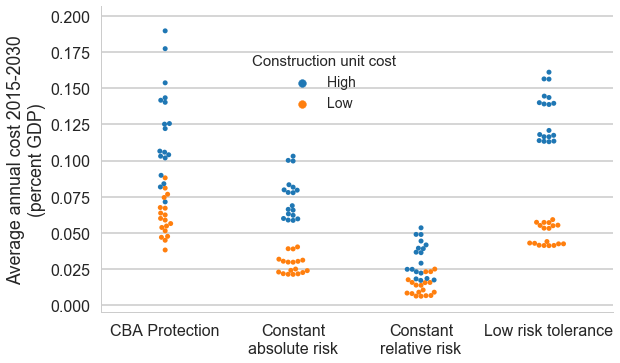

In [215]:
time_horizon = 2030

toplot = average_per_year_sumcountries
toplot = toplot.reset_index()
toplot = toplot.loc[toplot.time_horizon==2030,:]
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")

toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp

toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk','Constant Rel. Flood Risk':"Constant\nrelative risk"})

toplot['adacost'] = toplot.adacost.str.replace("Construction Unit Cost","")

g = sns.factorplot(x='ada',y='protection_inv_over_gdp', data=toplot,hue='adacost', kind="swarm",dodge=False, size=6, aspect=1.5,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)")
g.add_legend(title="Construction unit cost",fontsize = 14, bbox_to_anchor=(0.5, 0.65), borderaxespad=0.)

In [160]:
toplot.loc[toplot.ada=="Constant\nrelative risk","protection_inv_over_gdp"].describe()

count    36.000000
mean      0.022768
std       0.013689
min       0.006248
25%       0.012986
50%       0.018364
75%       0.030896
max       0.053528
Name: protection_inv_over_gdp, dtype: float64

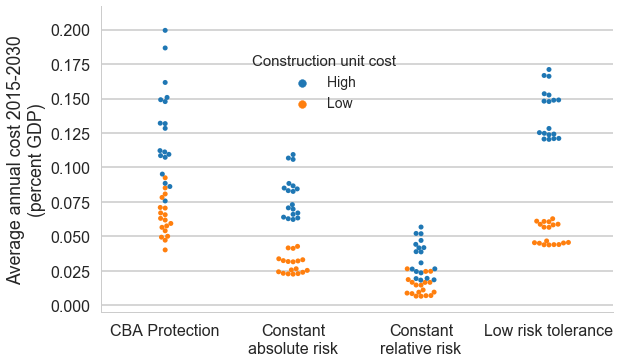

In [216]:
time_horizon = 2030

toplot = average_per_year_sumcoastcountries
toplot = toplot.reset_index()
toplot = toplot.loc[toplot.time_horizon==2030,:]
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")

toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp

toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk','Constant Rel. Flood Risk':"Constant\nrelative risk"})

toplot['adacost'] = toplot.adacost.str.replace("Construction Unit Cost","")

g = sns.factorplot(x='ada',y='protection_inv_over_gdp', data=toplot,hue='adacost', kind="swarm",dodge=False, size=6, aspect=1.5,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)")
g.add_legend(title="Construction unit cost",fontsize = 14, bbox_to_anchor=(0.5, 0.65), borderaxespad=0.)

#plt.savefig("coastal_inv_2030_pc_coastal.png".format(time_horizon),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_2030_pc_coastal.pdf".format(time_horizon),bbox_inches="tight")

In [136]:
toplot.loc[toplot.ada=="Constant\nrelative risk","protection_inv_over_gdp"].describe()

count    36.000000
mean      0.024326
std       0.014623
min       0.006684
25%       0.013880
50%       0.019637
75%       0.032987
max       0.057127
Name: protection_inv_over_gdp, dtype: float64

In [135]:
toplot.protection_inv_over_gdp.describe()

count    144.000000
mean       0.067797
std        0.045857
min        0.006684
25%        0.031610
50%        0.058205
75%        0.093280
max        0.199407
Name: protection_inv_over_gdp, dtype: float64

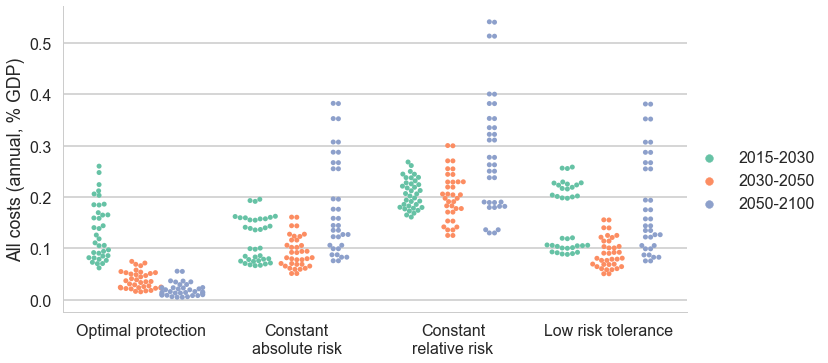

In [218]:
toplot = average_per_year_sumcountries.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]

toplot["time_horizon"] = toplot.time_horizon.replace({2030:"2015-2030",2050:"2030-2050",2100:"2050-2100"})
toplot["tot_cost_over_gdp"] = 100*toplot.tot_cost_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk',\
                                    'Constant Rel. Flood Risk':"Constant\nrelative risk",\
                                   'CBA Protection':"Optimal protection"})



g = sns.factorplot(x='ada',y='tot_cost_over_gdp', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False, palette = "Set2")

g.set_axis_labels("", "All costs (annual, % GDP)")
g.add_legend(title="")

plt.savefig("coastal_allcosts_pc_time.png",ddpi=300,bbox_inches="tight")
plt.savefig("coastal_allcosts_pc_time.pdf")

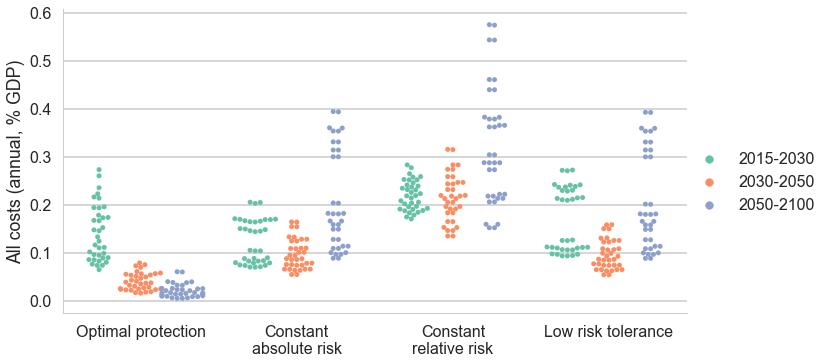

In [219]:
toplot = average_per_year_sumcoastcountries.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]

toplot["time_horizon"] = toplot.time_horizon.replace({2030:"2015-2030",2050:"2030-2050",2100:"2050-2100"})
toplot["tot_cost_over_gdp"] = 100*toplot.tot_cost_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk',\
                                    'Constant Rel. Flood Risk':"Constant\nrelative risk",\
                                   'CBA Protection':"Optimal protection"})



g = sns.factorplot(x='ada',y='tot_cost_over_gdp', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False, palette = "Set2")

g.set_axis_labels("", "All costs (annual, % GDP)")
g.add_legend(title="")

plt.savefig("coastal_allcosts_pc_time_coasts.png",ddpi=300,bbox_inches="tight")
plt.savefig("coastal_allcosts_pc_time_coasts.pdf")

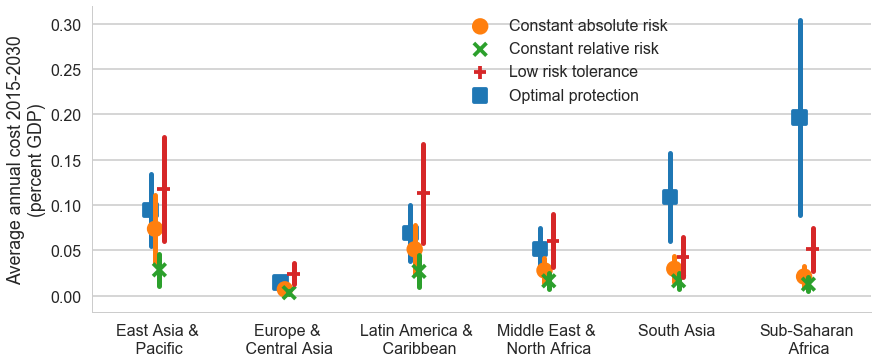

In [179]:
toplot = byregions.protection_inv_over_gdp.mean(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['wbregionname'] = toplot['wbregionname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")
toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant absolute risk',\
                                    'Constant Rel. Flood Risk':"Constant relative risk",\
                                   'CBA Protection':"Optimal protection"})

g = sns.factorplot(x='wbregionname',y='protection_inv_over_gdp', hue= 'ada', data=toplot, kind="point",dodge=True,join=False,\
                  errwidth=5, markers=["s",'o','x','+'],size=6, ci="sd", aspect=2.1, legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.6, 0.7), borderaxespad=0.)

#plt.savefig("coastal_inv_region_{}pc_dev.png".format(time_horizon),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_region_{}pc_dev.pdf".format(time_horizon))

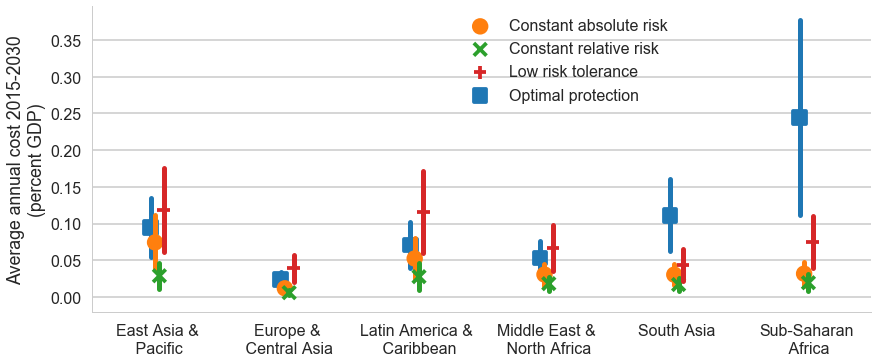

In [180]:
toplot = byregions_coasts.protection_inv_over_gdp.mean(level=['wbregionname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['wbregionname'] = toplot['wbregionname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")
toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant absolute risk',\
                                    'Constant Rel. Flood Risk':"Constant relative risk",\
                                   'CBA Protection':"Optimal protection"})

g = sns.factorplot(x='wbregionname',y='protection_inv_over_gdp', hue= 'ada', data=toplot, kind="point",dodge=True,join=False,\
                  errwidth=5, markers=["s",'o','x','+'],size=6, ci="sd", aspect=2.1, legend=False)

g.set_axis_labels("", "Average annual cost 2015-2030\n(percent GDP)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.6, 0.7), borderaxespad=0.)

#plt.savefig("coastal_inv_region_{}pc_dev.png".format(time_horizon),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_region_{}pc_dev.pdf".format(time_horizon))

# Best scenario

In [29]:
newdata_dev_world_sum_cum.reset_index().columns

Index(['rcp', 'ada', 'ssp', 'adacost', 'riverprotection', 'time_horizon', 'd',
       'protection_investment_cost_disc', 'protection_maintenance_cost_disc',
       'seafloodcost_disc'],
      dtype='object')

In [30]:
newdata_dev_world_sum_cum.reset_index().ssp.unique()

array(['SSP2', 'SSP3', 'SSP5'], dtype=object)

In [103]:
best_scenario = newdata_dev_world_sum_cum.reset_index()

select = (best_scenario.ada=="CBA Protection")&(best_scenario.ssp=="SSP2")&(best_scenario.adacost=='High Adaptation Unit Cost')&(best_scenario.riverprotection=='CBA River Protection')&\
(best_scenario.time_horizon==2030)&(best_scenario.d==0.06)

best_scenario = best_scenario.loc[select,:]

In [104]:
1/(2030-2015)*10**(-3)*best_scenario.set_index("rcp")[["protection_maintenance_cost_disc","protection_investment_cost_disc"]]

,protection_maintenance_cost_disc,protection_investment_cost_disc
rcp,,
RCP 2.6 (Low ice melting),38.866398,74.567100
RCP 4.5 (Medium ice melting),42.670550,90.628584
RCP 8.5 (High ice melting),49.700171,128.346645


In [33]:
dev_world_sum.reset_index().columns

Index(['rcp', 'ada', 'ssp', 'adacost', 'riverprotection', 'time', 'rslr',
       'par', 'pop_below_h100', 'riverdike_cost', 'riverdike_maintenance_cost',
       'seadike_cost', 'seadike_maintenance_cost', 'seafloodcost',
       'surge_barrier_cost', 'surge_barrier_maintenance_cost',
       'protection_investment_cost', 'protection_maintenance_cost', 'gdp',
       'protection_inv_over_gdp', 'protection_maint_over_gdp',
       'protection_cost_over_gdp', 'residual_risk_over_gdp',
       'tot_cost_over_gdp'],
      dtype='object')

In [105]:
best_scenario = dev_world_sum.reset_index()

select = (best_scenario.ada=="CBA Protection")&(best_scenario.ssp=="SSP2")&(best_scenario.adacost=='High Adaptation Unit Cost')&(best_scenario.riverprotection=='CBA River Protection')&\
(best_scenario.time<2031)

best_scenario = best_scenario.loc[select,['rcp','time','protection_inv_over_gdp', 'protection_maint_over_gdp']]

In [106]:
100*best_scenario.set_index(["time","rcp"]).mean(level=["rcp"])

,protection_inv_over_gdp,protection_maint_over_gdp
rcp,,
RCP 2.6 (Low ice melting),0.091233,0.059814
RCP 4.5 (Medium ice melting),0.109812,0.064096
RCP 8.5 (High ice melting),0.151716,0.071989


In [107]:
best_scenario = dev_world.reset_index()

select = (best_scenario.ada=="CBA Protection")&(best_scenario.ssp=="SSP2")&(best_scenario.adacost=='High Adaptation Unit Cost')&(best_scenario.riverprotection=='CBA River Protection')&\
(best_scenario.time<2031)&(best_scenario.rcp=='RCP 4.5 (Medium ice melting)')

best_scenario = best_scenario.loc[select,['rcp','time','protection_inv_over_gdp', 'protection_maint_over_gdp','locationname']]

In [108]:
100*best_scenario.set_index(["time","rcp","locationname"]).mean(level=["locationname"])

,protection_inv_over_gdp,protection_maint_over_gdp
locationname,,
East Asia & Pacific,0.115889,0.077196
Europe & Central Asia,0.016789,0.007834
Latin America & Caribbean,0.076603,0.078130
Middle East & North Africa,0.066328,0.031308
South Asia,0.138124,0.043896
Sub-Saharan Africa,0.225196,0.079157


# results for chapter

## graphs for the paper

In [93]:
world_undisc = originaldata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time'])[["protection_investment_cost"]].sum(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])

In [98]:
originaldata.time.unique().size

19

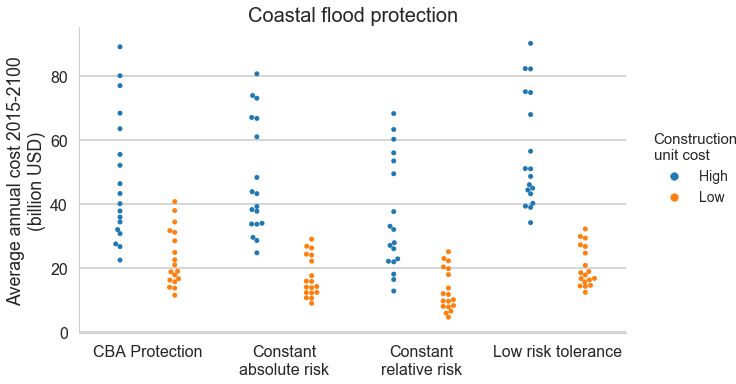

In [102]:
toplot = world_undisc
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['protection_investment_cost'] = 1/originaldata.time.unique().size*10**(-3)*toplot.protection_investment_cost
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")

toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk','Constant Rel. Flood Risk':"Constant\nrelative risk"})

toplot['adacost'] = toplot.adacost.str.replace("Construction Unit Cost","")

g = sns.factorplot(x='ada',y='protection_investment_cost', hue= 'adacost', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.5,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-2100\n(billion USD)")
g.add_legend(title="Construction\nunit cost",fontsize = 14, bbox_to_anchor=(1, 0.5), borderaxespad=0.)
plt.title("Coastal flood protection",fontsize=20)

plt.savefig("paper floods/coastal_inv_2100_0_world.png",ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_{}_{}_dev.pdf".format(time_horizon,round(100*d)))

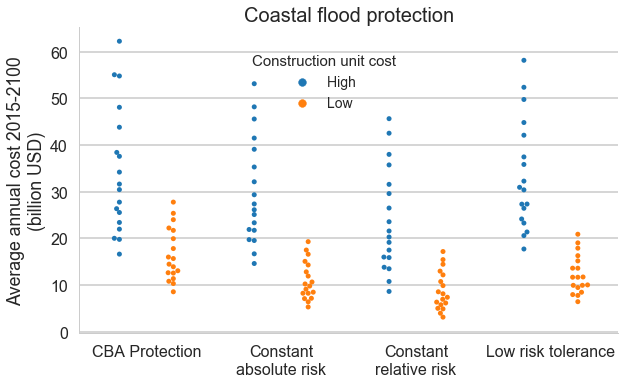

In [68]:
time_horizon = 2100
d = 0.0

toplot = newdata_dev_world_sum_cum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['protection_investment_cost_disc']]
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
#toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot["costtype"] = toplot["costtype"].replace({'protection_investment_cost_disc':'capital investment','protection_maintenance_cost_disc': 'maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 1/(time_horizon-2015)*10**(-3)*toplot.value
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")

toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk','Constant Rel. Flood Risk':"Constant\nrelative risk"})

toplot['adacost'] = toplot.adacost.str.replace("Construction Unit Cost","")

g = sns.factorplot(x='ada',y='value', hue= 'adacost', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.5,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-{}\n(billion USD)".format(time_horizon))
g.add_legend(title="Construction unit cost",fontsize = 14, bbox_to_anchor=(0.5, 0.7), borderaxespad=0.)
plt.title("Coastal flood protection",fontsize=20)

plt.savefig("paper floods/coastal_inv_{}_{}_dev.png".format(time_horizon,round(100*d)),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_{}_{}_dev.pdf".format(time_horizon,round(100*d)))

In [34]:
toplot.value.describe()

count    144.000000
mean      47.922617
std       32.771968
min        4.405872
25%       22.426463
50%       41.296658
75%       65.385051
max      149.320148
Name: value, dtype: float64

In [97]:
toplot.value.describe()

count    108.000000
mean      50.403967
std       36.092449
min        3.893075
25%       24.034041
50%       40.699688
75%       83.800451
max      149.320148
Name: value, dtype: float64

## Figure 5.2 report

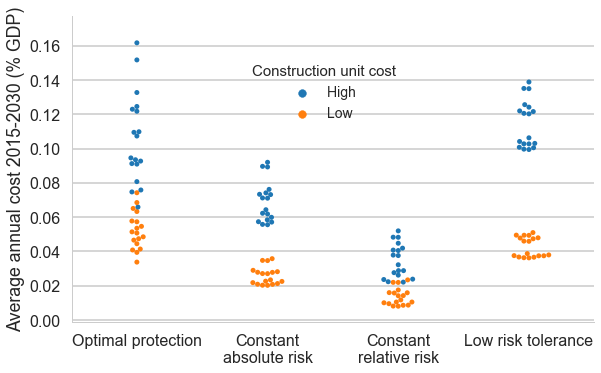

In [41]:
time_horizon = 2030

toplot = dev_world_sum.reset_index(['time'])
toplot = toplot.loc[(toplot.time<=time_horizon),['protection_inv_over_gdp']].mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
#toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")

toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk',\
                                    'Constant Rel. Flood Risk':"Constant\nrelative risk",\
                                   'CBA Protection':"Optimal protection"})

toplot['adacost'] = toplot.adacost.str.replace("Construction Unit Cost","")

g = sns.factorplot(x='ada',y='protection_inv_over_gdp', hue= 'adacost', data=toplot, kind="swarm",dodge=False, size=6, aspect=1.5,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-{} (% GDP)".format(time_horizon))
g.add_legend(title="Construction unit cost",fontsize = 14, bbox_to_anchor=(0.5, 0.65), borderaxespad=0.)

plt.savefig("coastal_inv_{}_pc.png".format(time_horizon),ddpi=300,bbox_inches="tight")
plt.savefig("coastal_inv_{}_pc.pdf".format(time_horizon),bbox_inches="tight")

In [36]:
toplot.loc[toplot.ada=="Constant\nrelative risk","protection_inv_over_gdp"].describe()

count    36.000000
mean      0.024268
std       0.013226
min       0.008034
25%       0.013530
50%       0.022203
75%       0.033554
max       0.051986
Name: protection_inv_over_gdp, dtype: float64

In [79]:
toplot.loc[toplot.ada=="CBA Protection","protection_inv_over_gdp"].describe()

count    36.000000
mean      0.078913
std       0.033641
min       0.033766
25%       0.051245
50%       0.071367
75%       0.097744
max       0.161692
Name: protection_inv_over_gdp, dtype: float64

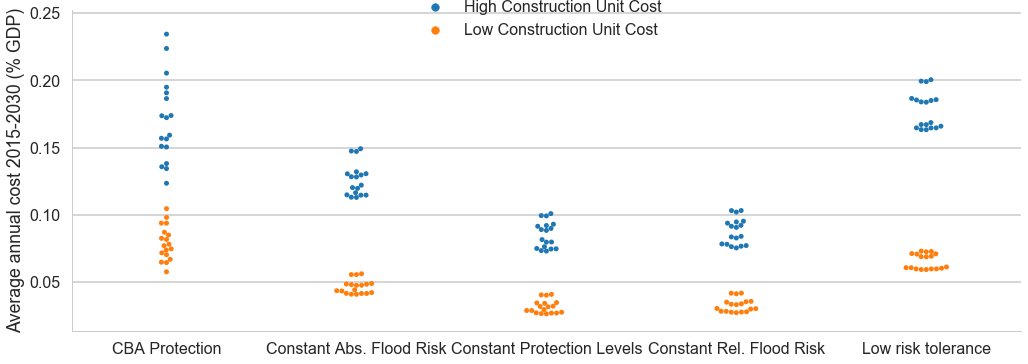

In [81]:
time_horizon = 2030

toplot = dev_world_sum.reset_index(['time'])
toplot = toplot.loc[(toplot.time<=time_horizon),['protection_cost_over_gdp']].mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
#toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
#toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['protection_cost_over_gdp'] = 100*toplot.protection_cost_over_gdp
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance"})

g = sns.factorplot(x='ada',y='protection_cost_over_gdp', hue= 'adacost', data=toplot, kind="swarm",dodge=False, size=6, aspect=2.5,\
                  legend=False)

g.set_axis_labels("", "Average annual cost 2015-{} (% GDP)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.8), borderaxespad=0.)



In [82]:
toplot.loc[toplot.ada=="Constant Rel. Flood Risk","protection_cost_over_gdp"].describe()

count    36.000000
mean      0.060411
std       0.028884
min       0.027483
25%       0.032727
50%       0.058793
75%       0.085818
max       0.103348
Name: protection_cost_over_gdp, dtype: float64

In [83]:
toplot.loc[toplot.ada=="CBA Protection","protection_cost_over_gdp"].describe()

count    36.000000
mean      0.124768
std       0.051623
min       0.057816
25%       0.078050
50%       0.114171
75%       0.162573
max       0.234376
Name: protection_cost_over_gdp, dtype: float64

In [32]:
time_horizon = 2030

toplot = dev_world_sum.reset_index(['time'])
toplot = toplot.loc[(toplot.time<=time_horizon),['protection_cost_over_gdp']].mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
#toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['protection_cost_over_gdp'] = 100*toplot.protection_cost_over_gdp

toplot.protection_cost_over_gdp.describe()

count    108.000000
mean       0.101681
std        0.056228
min        0.026631
25%        0.061297
50%        0.080849
75%        0.160336
max        0.234376
Name: protection_cost_over_gdp, dtype: float64

In [100]:
toplot.set_index("ada").protection_inv_over_gdp.min(level="ada")

ada
CBA Protection                0.033766
Constant Protection Levels    0.007365
Low risk tolerance            0.036243
Name: protection_inv_over_gdp, dtype: float64

In [101]:
toplot.set_index("ada").protection_inv_over_gdp.max(level="ada")

ada
CBA Protection                0.161692
Constant Protection Levels    0.048707
Low risk tolerance            0.138840
Name: protection_inv_over_gdp, dtype: float64

## Figure 5.5 report

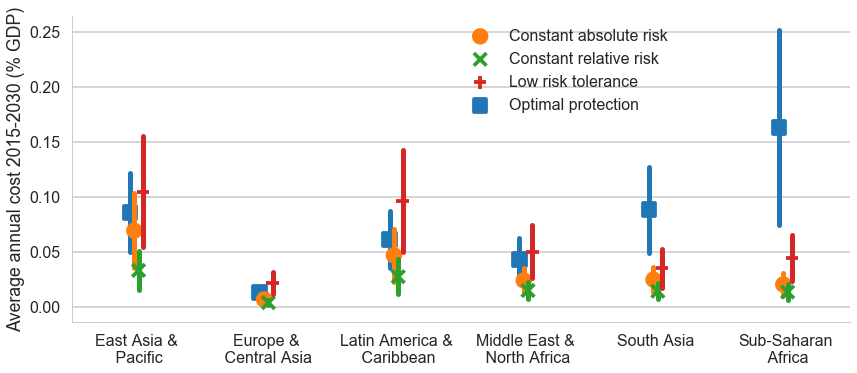

In [60]:
time_horizon = 2030

toplot = dev_world
toplot = toplot.loc[(toplot.time<=time_horizon),['protection_inv_over_gdp']].mean(level=['locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")
toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant absolute risk',\
                                    'Constant Rel. Flood Risk':"Constant relative risk",\
                                   'CBA Protection':"Optimal protection"})

g = sns.factorplot(x='locationname',y='protection_inv_over_gdp', hue= 'ada', data=toplot, kind="point",dodge=True,join=False,\
                  errwidth=5, markers=["s",'o','x','+'],size=6, ci="sd", aspect=2.1, legend=False)

g.set_axis_labels("", "Average annual cost 2015-{} (% GDP)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.6, 0.7), borderaxespad=0.)

plt.savefig("coastal_inv_region_{}pc_dev.png".format(time_horizon),ddpi=300,bbox_inches="tight")
plt.savefig("coastal_inv_region_{}pc_dev.pdf".format(time_horizon))

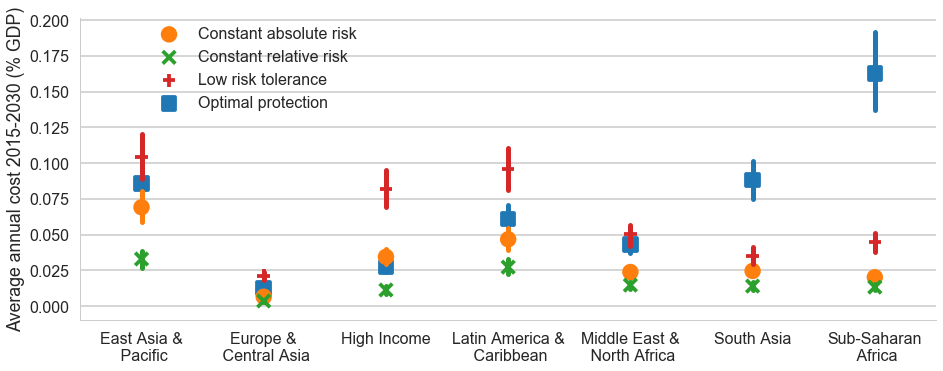

In [63]:
time_horizon = 2030

toplot = mydata
toplot = toplot.loc[(toplot.time<=time_horizon),['protection_inv_over_gdp']].mean(level=['locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")
toplot['protection_inv_over_gdp'] = 100*toplot.protection_inv_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant absolute risk',\
                                    'Constant Rel. Flood Risk':"Constant relative risk",\
                                   'CBA Protection':"Optimal protection"})

g = sns.factorplot(x='locationname',y='protection_inv_over_gdp', hue= 'ada', data=toplot, kind="point",dodge=False,join=False,\
                  errwidth=5, markers=["s",'o','x','+'],size=6, aspect=2.3, legend=False)

g.set_axis_labels("", "Average annual cost 2015-{} (% GDP)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.3, 0.7), borderaxespad=0.)

plt.savefig("coastal_inv_region_{}pc_annex_all.png".format(time_horizon),ddpi=300,bbox_inches="tight")
plt.savefig("coastal_inv_region_{}pc_annex_all.pdf".format(time_horizon))

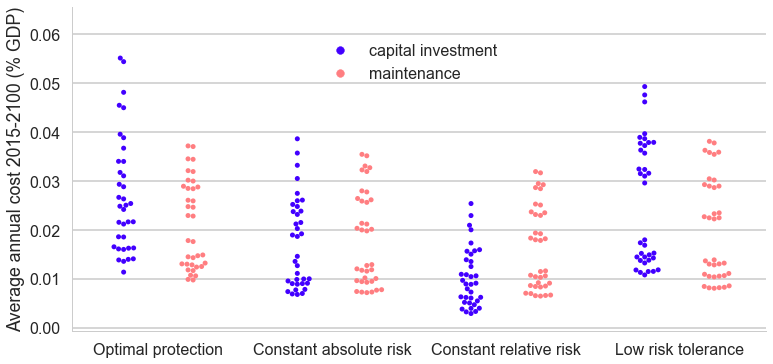

In [65]:
time_horizon = [2015,2100]

toplot = dev_world_sum.reset_index(['time'])
toplot = toplot.loc[(toplot.time>=time_horizon[0])&(toplot.time<time_horizon[1]),['protection_inv_over_gdp','protection_maint_over_gdp']].mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]
#toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot["costtype"] = toplot["costtype"].replace({'protection_inv_over_gdp':'capital investment','protection_maint_over_gdp': 'maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 100*toplot.value
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant absolute risk',\
                                    'Constant Rel. Flood Risk':"Constant relative risk",\
                                   'CBA Protection':"Optimal protection"})

g = sns.factorplot(x='ada',y='value', hue= 'costtype', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.9,\
                  legend=False, palette='gnuplot2')

g.set_axis_labels("", "Average annual cost {}-{} (% GDP)".format(time_horizon[0],time_horizon[1]))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.7), borderaxespad=0.)

plt.savefig("coastal_inv_maint_{}_{}pc.png".format(time_horizon[0],time_horizon[1]),ddpi=300,bbox_inches="tight")
plt.savefig("coastal_inv_maint_{}_{}pc.pdf".format(time_horizon[0],time_horizon[1]))

In [66]:
toplot.loc[toplot.costtype=="maintenance","value"].describe()

count    144.000000
mean       0.018984
std        0.009506
min        0.006441
25%        0.010500
50%        0.017785
75%        0.028026
max        0.038028
Name: value, dtype: float64

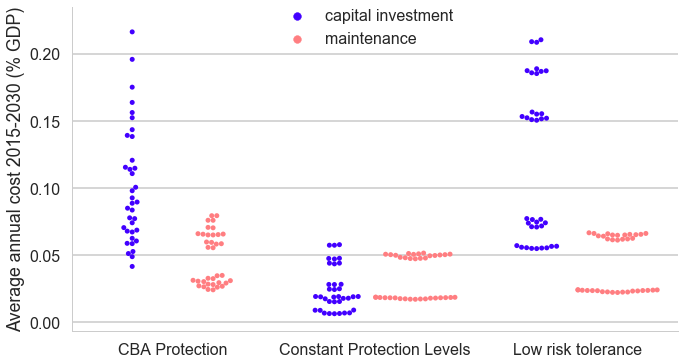

In [108]:
time_horizon = [2015,2030]

toplot = dev_world_sum.reset_index(['time'])
toplot = toplot.loc[(toplot.time>=time_horizon[0])&(toplot.time<time_horizon[1]),['protection_inv_over_gdp','protection_maint_over_gdp']].mean(level=['rcp', 'ada', 'ssp', 'adacost','riverprotection'])
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
#toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot["costtype"] = toplot["costtype"].replace({'protection_inv_over_gdp':'capital investment','protection_maint_over_gdp': 'maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 100*toplot.value
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance"})

g = sns.factorplot(x='ada',y='value', hue= 'costtype', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False, palette='gnuplot2')

g.set_axis_labels("", "Average annual cost {}-{} (% GDP)".format(time_horizon[0],time_horizon[1]))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.78), borderaxespad=0.)

#plt.savefig("coastal_inv_maint_{}_{}pc.png".format(time_horizon[0],time_horizon[1]),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_maint_{}_{}pc.pdf".format(time_horizon[0],time_horizon[1]))

In [110]:
toplot.loc[toplot.costtype=="capital investment","value"].describe()

count    108.000000
mean       0.081545
std        0.059206
min        0.006337
25%        0.038217
50%        0.067497
75%        0.125014
max        0.216170
Name: value, dtype: float64

In [109]:
toplot.loc[toplot.costtype=="maintenance","value"].describe()

count    108.000000
mean       0.041729
std        0.019625
min        0.017086
25%        0.023541
50%        0.041039
75%        0.061838
max        0.079331
Name: value, dtype: float64

In [37]:
toplot.loc[toplot.ada=="CBA Protection",:].set_index(["rcp","ada","ssp","adacost","riverprotection","costtype"]).unstack("costtype").sum(axis=1).min()

0.065946728942421012

In [38]:
toplot.loc[toplot.ada=="CBA Protection",:].set_index(["rcp","ada","ssp","adacost","riverprotection","costtype"]).unstack("costtype").sum(axis=1).max()

0.29548050402098908

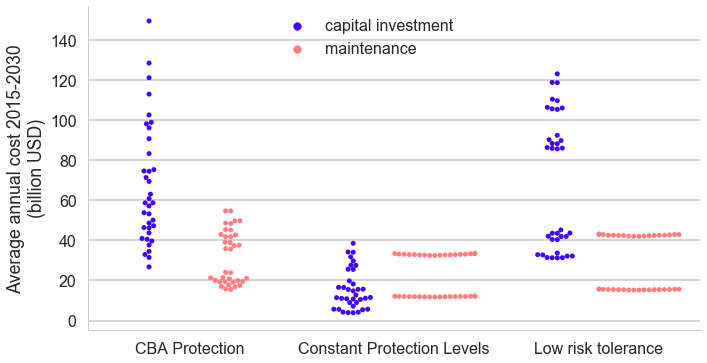

In [105]:
time_horizon = 2030
d = 0.06

toplot = newdata_dev_world_sum_cum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['protection_investment_cost_disc','protection_maintenance_cost_disc']]
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["costtype"] = toplot["costtype"].replace({'protection_investment_cost_disc':'capital investment','protection_maintenance_cost_disc': 'maintenance'})
toplot['value'] = 1/(time_horizon-2015)*10**(-3)*toplot.value
toplot['adacost'] = toplot['adacost'].str.replace("Adaptation","Construction")
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance"})

g = sns.factorplot(x='ada',y='value', hue= 'costtype', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False, palette='gnuplot2')

g.set_axis_labels("", "Average annual cost 2015-{}\n(billion USD)".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.755), borderaxespad=0.)

#plt.savefig("coastal_inv_maint_{}_dev.png".format(time_horizon),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_inv_maint_{}_dev.pdf".format(time_horizon))

In [107]:
toplot.loc[toplot.costtype=="maintenance","value"].describe()

count    108.000000
mean      27.676671
std       13.066430
min       11.735126
25%       15.428941
50%       28.218955
75%       41.941096
max       54.641002
Name: value, dtype: float64

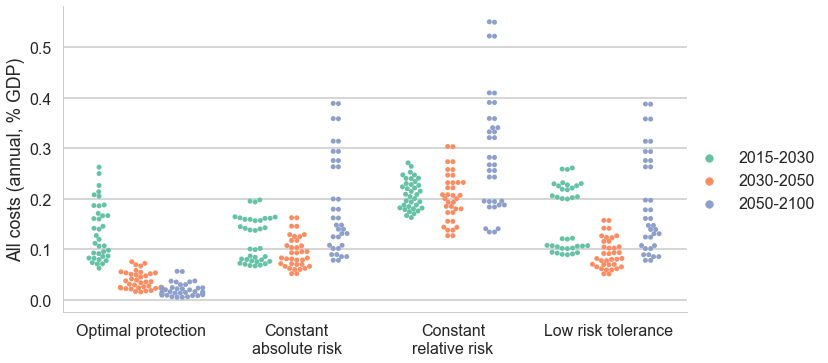

In [39]:
toplot = average_per_year_data.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Protection Levels'),:]

toplot["time_horizon"] = toplot.time_horizon.replace({2030:"2015-2030",2050:"2030-2050",2100:"2050-2100"})
toplot["tot_cost_over_gdp"] = 100*toplot.tot_cost_over_gdp
toplot['ada'] = toplot.ada.replace({"Risk intolerance":"Low risk tolerance",'Constant Abs. Flood Risk':'Constant\nabsolute risk',\
                                    'Constant Rel. Flood Risk':"Constant\nrelative risk",\
                                   'CBA Protection':"Optimal protection"})



g = sns.factorplot(x='ada',y='tot_cost_over_gdp', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False, palette = "Set2")

g.set_axis_labels("", "All costs (annual, % GDP)")
g.add_legend(title="")

plt.savefig("coastal_allcosts_pc_time.png",ddpi=300,bbox_inches="tight")
plt.savefig("coastal_allcosts_pc_time.pdf")

## Adapatation deficit

In [ ]:
originaldata = originaldata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])

This one assumes all the investments are made in 2015

In [261]:
originaldata.loc[(originaldata.time==2010)|(originaldata.time==2015),"protection_investment_cost"].sum(level=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection']).unstack("rcp")["RCP 2.6 (Low ice melting)"].unstack("ada")[["CBA Protection","Constant Protection Levels"]].diff(axis=1)["Constant Protection Levels"].mean(level=["locationid","locationname"])*5/2

locationid  locationname              
EAP         East Asia & Pacific          -281334.499131
ECA         Europe & Central Asia          -4931.901700
LAC         Latin America & Caribbean     -46377.634732
MNA         Middle East & North Africa    -19678.769453
SAS         South Asia                   -134110.851053
SSA         Sub-Saharan Africa            -73075.473881
YHI         High Income                  -141757.783726
Name: Constant Protection Levels, dtype: float64

This one assumes investments are spread over 2015-2030, so investments in 2015 are smaller

In [287]:
mydata.loc[(mydata.time==2010)|(mydata.time==2015),"protection_investment_cost"].sum(level=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection']).unstack("rcp")["RCP 2.6 (Low ice melting)"].unstack("ada")[["CBA Protection","Constant Protection Levels"]].diff(axis=1)["Constant Protection Levels"].mean(level=["locationid","locationname"])*5

locationid  locationname              
EAP         East Asia & Pacific          -74804.406225
ECA         Europe & Central Asia         -1615.030923
LAC         Latin America & Caribbean       -68.616921
MNA         Middle East & North Africa    -6333.662251
SAS         South Asia                   -49197.970034
SSA         Sub-Saharan Africa           -28090.217767
YHI         High Income                    3511.811945
Name: Constant Protection Levels, dtype: float64

## sums over time

In [23]:
newdatacum = newdata.sum(level=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time_horizon','d'])

In [25]:
newdatacum.protection_investment_cost_disc.unstack("time_horizon")[2030].unstack("d")[0.03].unstack("rcp")["RCP 2.6 (Low ice melting)"].unstack("ada")[["CBA Protection","Constant Protection Levels"]].diff(axis=1)["Constant Protection Levels"].mean(level=["locationid","locationname"])

locationid  locationname              
EAP         East Asia & Pacific          -90777.348596
ECA         Europe & Central Asia         -1802.575704
LAC         Latin America & Caribbean    -16003.137083
MNA         Middle East & North Africa    -6102.441188
SAS         South Asia                   -45143.546990
SSA         Sub-Saharan Africa           -26153.072327
YHI         High Income                  -48827.004827
Name: Constant Protection Levels, dtype: float64

In [26]:
newdatacum["tot_cost"] = newdatacum.protection_investment_cost_disc+newdatacum.protection_maintenance_cost_disc

In [27]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [28]:
time_horizon = 2030
d = 0.06

explore = newdatacum.reset_index(['time_horizon','d','locationid']).drop('locationid',axis=1)
explore = explore.loc[(explore.time_horizon==time_horizon)&(explore.d==d),['protection_investment_cost_disc']]

explore = explore.stack().unstack("locationname")
explore['world'] = explore.sum(axis=1)

explore = explore.div(explore.world,axis=0)

In [29]:
explore.columns

Index(['East Asia & Pacific', 'Europe & Central Asia', 'High Income',
       'Latin America & Caribbean', 'Middle East & North Africa', 'South Asia',
       'Sub-Saharan Africa', 'world'],
      dtype='object', name='locationname')

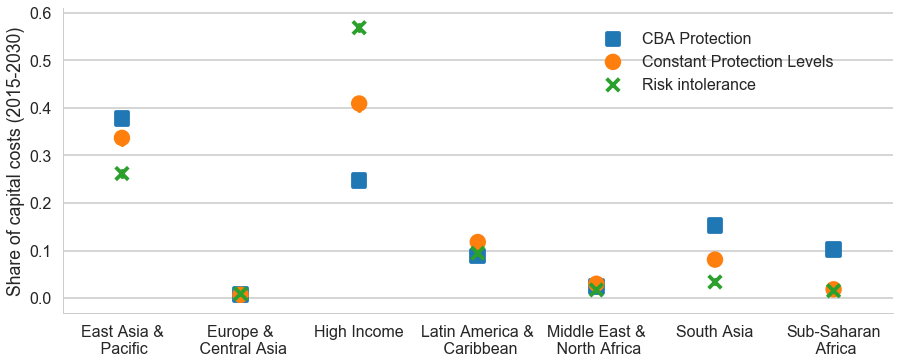

In [31]:
toplot = explore.drop(["world"],axis=1).stack().reset_index().rename(columns={0:"share"})
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")

g = sns.factorplot(x='locationname',y='share', hue ='ada', data=toplot, kind="point",dodge=False, join=False,\
                   errwidth=5, markers=["s",'o','x'],size=6, aspect=2.2,\
                  legend=False)

g.set_axis_labels("", "Share of capital costs (2015-2030)".format(time_horizon,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.7, 0.7), borderaxespad=0.)

plt.savefig("regional_share_invest_{}_{}pc.png".format(time_horizon,round(100*d)),ddpi=300,bbox_inches="tight")
plt.savefig("regional_share_invest_{}_{}pc.pdf".format(time_horizon,round(100*d)))

In [97]:
explore.drop("world",axis=1).mean(level=['ada'])

locationname,East Asia & Pacific,Europe & Central Asia,High Income,Latin America & Caribbean,Middle East & North Africa,South Asia,Sub-Saharan Africa
ada,,,,,,,
CBA Protection Levels,0.471992,0.005340,0.184007,0.061666,0.024888,0.172162,0.079946
Constant Abs. Flood Risk,0.574570,0.005095,0.268480,0.081103,0.014394,0.037409,0.018948
Constant Protection Levels,0.605990,0.003389,0.243023,0.077779,0.014519,0.038537,0.016763
Constant Rel. Flood Risk,0.645346,0.004024,0.202616,0.074900,0.014164,0.040704,0.018246
Risk intolerance,0.466566,0.005398,0.387609,0.075793,0.013931,0.034403,0.016300


In [72]:
time_horizon = 2100
d = 0.03

share_risk = newdatacum.reset_index(['time_horizon','d','locationid']).drop('locationid',axis=1)
share_risk = share_risk.loc[(share_risk.time_horizon==time_horizon)&(share_risk.d==d),['seafloodcost_disc']]

share_risk = share_risk.stack().unstack("locationname")
share_risk['world'] = share_risk.sum(axis=1)

share_risk = share_risk.div(share_risk.world,axis=0)

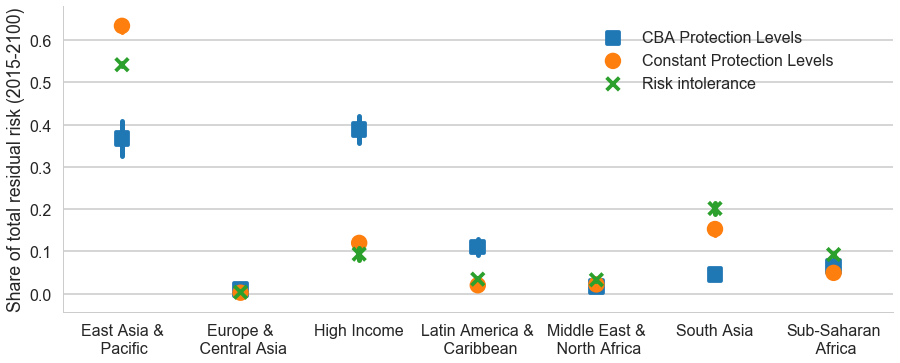

In [73]:
toplot = share_risk.drop("world",axis=1).stack().reset_index().rename(columns={0:"share"})
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")

g = sns.factorplot(x='locationname',y='share', hue ='ada', data=toplot, kind="point",dodge=False, join=False,\
                   errwidth=5, markers=["s",'o','x'],ci='sd', size=6, aspect=2.2,\
                  legend=False)

g.set_axis_labels("", "Share of total residual risk (2015-{})".format(time_horizon,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.7, 0.7), borderaxespad=0.)

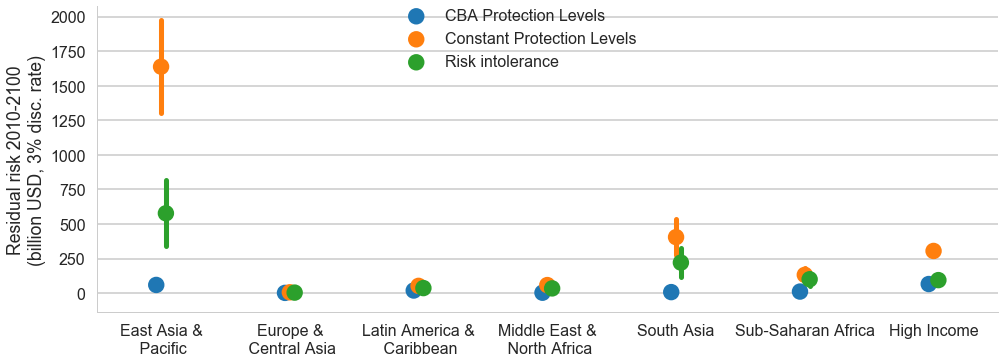

In [77]:
time_horizon = 2100
d = 0.03

toplot = newdatacum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['seafloodcost_disc']]
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['seafloodcost_disc'] = 10**(-3)*toplot.seafloodcost_disc
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n")

g = sns.factorplot(x='locationname',y='seafloodcost_disc', hue= 'ada', data=toplot, kind="point",ci='sd',dodge=True,join=False, size=6, aspect=2.4,\
                  legend=False)

g.set_axis_labels("", "Residual risk 2010-{}\n(billion USD, {}% disc. rate)".format(time_horizon,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.75), borderaxespad=0.)

#plt.savefig("coastal_{}_{}pc.png".format(time_horizon-5,round(100*d)),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_{}_{}pc.pdf".format(time_horizon-5,round(100*d)))

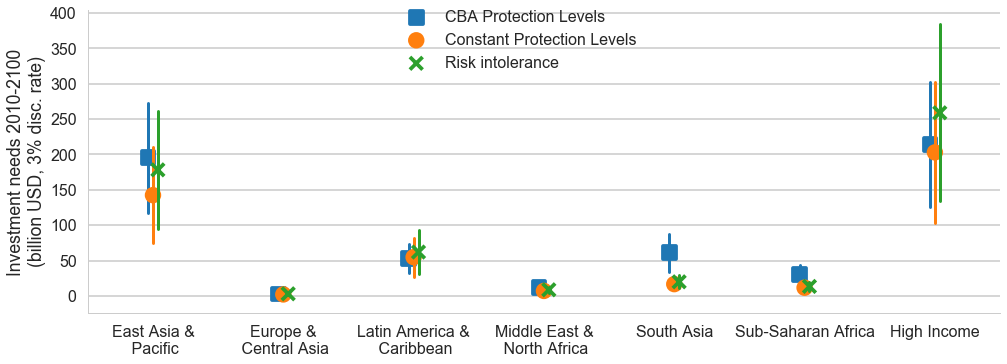

In [80]:
time_horizon = 2100
d = 0.03

toplot = newdatacum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['tot_cost']]
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['tot_cost'] = 10**(-3)*toplot.tot_cost
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n")

g = sns.factorplot(x='locationname',y='tot_cost', hue= 'ada', data=toplot, kind="point",ci='sd',dodge=True,join=False, size=6, aspect=2.4,\
                  errwidth=3, markers=["s",'o','x'],legend=False)

g.set_axis_labels("", "Investment needs 2010-{}\n(billion USD, {}% disc. rate)".format(time_horizon,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.75), borderaxespad=0.)

#plt.savefig("coastal_{}_{}pc.png".format(time_horizon-5,round(100*d)),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_{}_{}pc.pdf".format(time_horizon-5,round(100*d)))

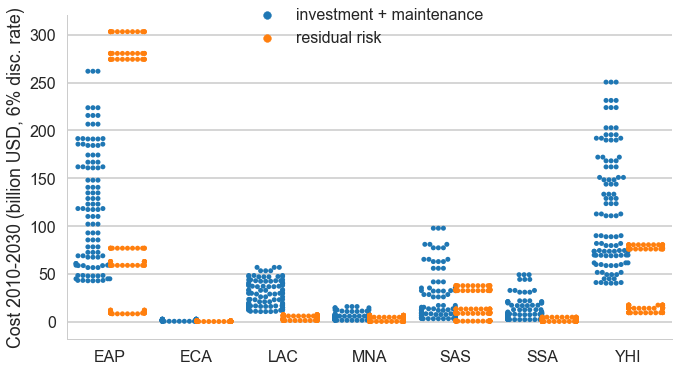

In [23]:
time_horizon = 2030
d = 0.06

toplot = newdatacum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['tot_cost','seafloodcost_disc']]
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 10**(-3)*toplot.value

g = sns.factorplot(x='locationid',y='value', hue= 'costtype', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False)

g.set_axis_labels("", "Cost 2010-{} (billion USD, {}% disc. rate)".format(time_horizon,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.8), borderaxespad=0.)

#plt.savefig("coastal_{}_{}pc.png".format(time_horizon-5,round(100*d)),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_{}_{}pc.pdf".format(time_horizon-5,round(100*d)))

In [317]:
newdatacum['all_costs'] = newdatacum[['tot_cost','seafloodcost_disc']].sum(axis=1)

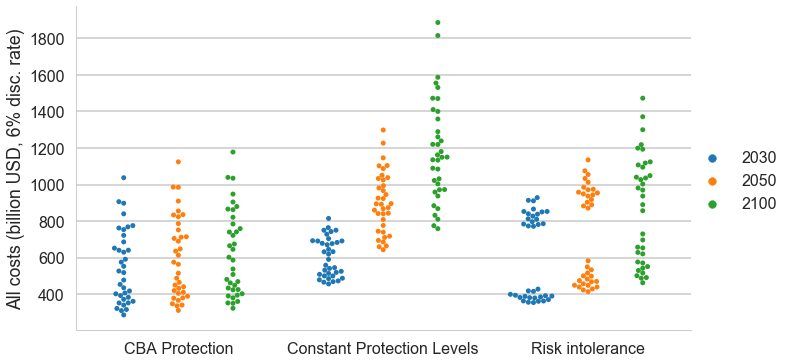

In [287]:
d = 0.06

toplot = newdatacum.reset_index()
toplot = toplot.loc[(toplot.d==d),:]
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["time_horizon"] = toplot.time_horizon.replace({2035:2030,2055:2050,2105:2100})
toplot['all costs'] = 10**(-3)*toplot['all costs']

g = sns.factorplot(x='ada',y='all costs', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False)

g.set_axis_labels("", "All costs (billion USD, {}% disc. rate)".format(round(100*d)))
g.add_legend(title="")

plt.savefig("coastal_allcosts_{}pc.png".format(round(100*d)),ddpi=300,bbox_inches="tight")
plt.savefig("coastal_allcosts_{}pc.pdf".format(round(100*d)))

In [34]:
mydata.columns

Index(['time', 'rslr', 'par', 'pop_below_h100', 'riverdike_cost',
       'riverdike_maintenance_cost', 'seadike_cost',
       'seadike_maintenance_cost', 'seafloodcost', 'surge_barrier_cost',
       'surge_barrier_maintenance_cost', 'protection_investment_cost',
       'protection_maintenance_cost', 'gdp'],
      dtype='object')

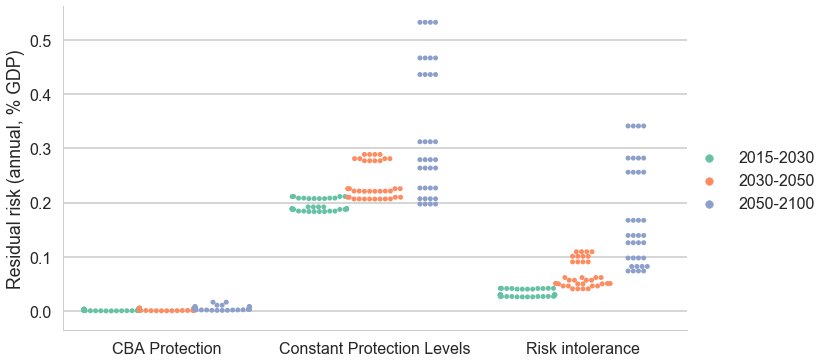

In [62]:
toplot = average_per_year_data.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]

toplot["time_horizon"] = toplot.time_horizon.replace({2030:"2015-2030",2050:"2030-2050",2100:"2050-2100"})
toplot["residual_risk_over_gdp"] = 100*toplot.residual_risk_over_gdp


g = sns.factorplot(x='ada',y='residual_risk_over_gdp', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False, palette = "Set2")

g.set_axis_labels("", "Residual risk (annual, % GDP)")
g.add_legend(title="")

#plt.savefig("coastal_allcosts_pc.png",ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_allcosts_pc.pdf")

In [301]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [325]:
def drivers_from_anova(varin,mydata):
    formula=varin+" ~ rcp+ssp+adacost+riverprotection+ada"
    olsmodel=ols(formula,data=mydata).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort_values(by=['sum_sq'],ascending=False)
    sumvar=0
    drivers=list()
    for var in table.index:
        if var!='Residual':
            drivers.append(var)
            sumvar+=table.loc[var,'sum_sq_pc']
        if len(drivers)==3:
            break
    return drivers,sumvar

In [326]:
for (time),subframe in newdatacum.reset_index('d').loc[newdatacum.reset_index('d').d==0.03,:].groupby(level=["time_horizon"]):
    drivers,sumvar = drivers_from_anova("tot_cost",subframe.reset_index())
    print(time,drivers,sumvar)

2035 ['adacost', 'ada', 'riverprotection'] 0.88960406054
2055 ['adacost', 'ada', 'rcp'] 0.908052141858
2105 ['adacost', 'ada', 'rcp'] 0.92309249683


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [327]:
for (time),subframe in newdatacum.reset_index('d').loc[newdatacum.reset_index('d').d==0.03,:].groupby(level=["time_horizon"]):
    drivers,sumvar = drivers_from_anova("seafloodcost_disc",subframe.reset_index())
    print(time,drivers,sumvar)

2035 ['ada', 'rcp', 'ssp'] 0.993206819106
2055 ['ada', 'ssp', 'rcp'] 0.964578853967
2105 ['ada', 'rcp', 'ssp'] 0.896475219602


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [328]:
for (time),subframe in newdatacum.reset_index('d').loc[newdatacum.reset_index('d').d==0.03,:].groupby(level=["time_horizon"]):
    drivers,sumvar = drivers_from_anova("all_costs",subframe.reset_index())
    print(time,drivers,sumvar)

2035 ['adacost', 'ada', 'rcp'] 0.86429449855
2055 ['ada', 'adacost', 'rcp'] 0.891986822397
2105 ['ada', 'rcp', 'ssp'] 0.838985879339


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [332]:
diff = newdatacum['all_costs'].unstack("ada")[['Constant Protection Levels','Risk intolerance']].diff(axis=1)

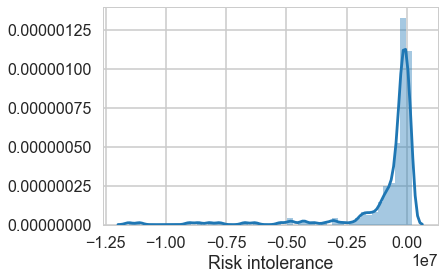

In [333]:
sns.distplot(diff['Risk intolerance'])

In [334]:
sum(diff['Risk intolerance']>0)/sum(diff['Risk intolerance']<0)

0.29729729729729731

In [335]:
forprim = diff['Risk intolerance'].reset_index()

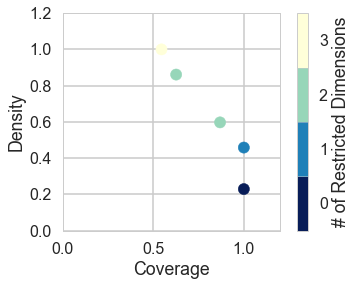

In [337]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection','time_horizon','d']], forprim['Risk intolerance'],\
              threshold=0.0001, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [339]:
box.select(3)
print(box.coverage,box.density)
box.limits

0.626262626263 0.861111111111


,min,max,qp values
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},4.449371e-14
time_horizon,2035,2035,1.322525e-12


In [49]:
oois = ['tot_cost','seafloodcost_disc']

data = np.array([[newdatacum[oois[0]][0],newdatacum[oois[1]][0]]])
for i in range(1,len(newdatacum.index)):
    data = np.concatenate((data,np.array([[newdatacum[oois[0]][i],newdatacum[oois[1]][i]]])))

data_norm = normalize(data)

In [50]:
inputs = newdatacum.reset_index()[['rcp', 'ada', 'ssp', 'adacost','riverprotection']]

In [54]:
n_clusters = 6
f_value = 0.5
seuil = 1.2

In [55]:
dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)
boxes = dummy[0]
df = dummy[1]

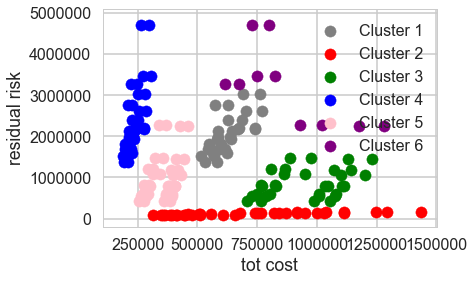

In [56]:
mycolors = ["grey","red","green","blue","pink","purple"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf.tot_cost,subdf.seafloodcost_disc,label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.xlabel("tot cost")
plt.ylabel("residual risk")

In [57]:
boxes[0].limits

,min,max,qp values
ada,"{Constant Protection Levels, Constant Rel. Flo...","{Constant Protection Levels, Constant Rel. Flo...",9.175853e-10
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},3.477975e-07


In [58]:
boxes[1].limits

,min,max,qp values
ada,{CBA Protection},{CBA Protection},6.871948e-26


In [59]:
boxes[2].limits

,min,max,qp values
ada,"{Constant Abs. Flood Risk, Risk intolerance}","{Constant Abs. Flood Risk, Risk intolerance}",4.628203e-11
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},3.328461e-08


In [60]:
boxes[3].limits

,min,max,qp values
ada,"{Constant Protection Levels, Constant Rel. Flo...","{Constant Protection Levels, Constant Rel. Flo...",4.722366e-15
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},1.455192e-11


In [61]:
boxes[4].limits

,min,max,qp values
ada,"{Constant Abs. Flood Risk, Risk intolerance}","{Constant Abs. Flood Risk, Risk intolerance}",4.722366e-15
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},1.455192e-11


In [62]:
boxes[5].limits

,min,max,qp values
ssp,{SSP5},{SSP5},0.000352
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},0.009780
rcp,"{RCP 8.5 (High ice melting), RCP 4.5 (Medium i...","{RCP 8.5 (High ice melting), RCP 4.5 (Medium i...",0.076404
ada,"{Constant Abs. Flood Risk, Constant Protection...","{Constant Abs. Flood Risk, Constant Protection...",0.227249


In [65]:
forprim = newdatacum[['tot_cost','seafloodcost_disc']].sum(axis=1).reset_index().rename(columns={0:"all_costs"})

In [67]:
forprim.all_costs.describe()

count    1.800000e+02
mean     1.956612e+06
std      1.039750e+06
min      4.119737e+05
25%      1.139432e+06
50%      1.856185e+06
75%      2.577746e+06
max      5.510730e+06
Name: all_costs, dtype: float64

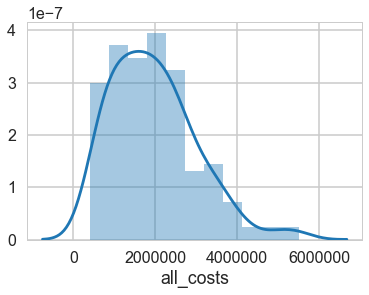

In [68]:
sns.distplot(forprim.all_costs)

In [72]:
forprim.ada.unique()

array(['CBA Protection', 'Constant Abs. Flood Risk',
       'Constant Protection Levels', 'Constant Rel. Flood Risk',
       'Risk intolerance'], dtype=object)

In [74]:
adadict = {'CBA Protection':'CBA', 'Constant Abs. Flood Risk':"c_abs",
       'Constant Protection Levels':'c', 'Constant Rel. Flood Risk':'c_rel',
       'Risk intolerance':'int'}

In [75]:
forprim['ada'] = forprim.ada.replace(adadict)

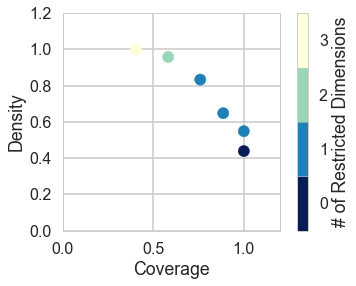

In [87]:
p = prim.Prim(forprim[['rcp', 'ada', 'ssp', 'adacost','riverprotection']], forprim.all_costs,\
              threshold=2.0e+06, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [88]:
box.select(3)
print(box.coverage,box.density)
box.limits

0.759493670886 0.833333333333


,min,max,qp values
ada,"{c_rel, c}","{c_rel, c}",6.131459e-12


In [177]:
diff = newdatacum.tot_cost.unstack("ada")[['Risk intolerance','CBA Protection']].diff(axis=1)

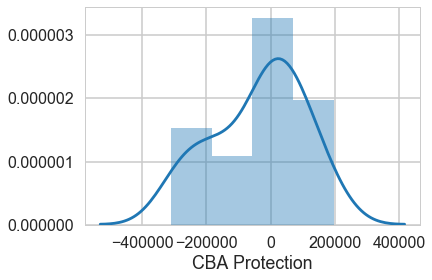

In [178]:
sns.distplot(diff['CBA Protection'])

In [168]:
forprim=diff['CBA Protection'].reset_index()

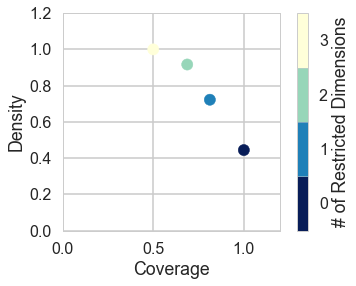

In [179]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection']], forprim['CBA Protection'],\
              threshold=1, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [180]:
box.select(1)
print(box.coverage,box.density)
box.limits

0.8125 0.722222222222


,min,max,qp values
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},0.016242


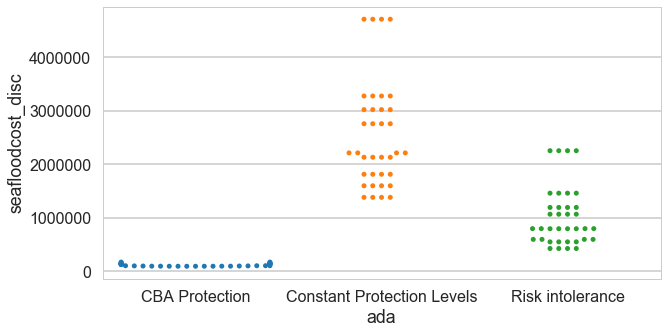

In [248]:
toplot = newdatacum.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]

fig, ax = plt.subplots()
sns.swarmplot(x='ada',y='seafloodcost_disc',data=toplot,ax=ax)
fig.set_size_inches(10, 5)

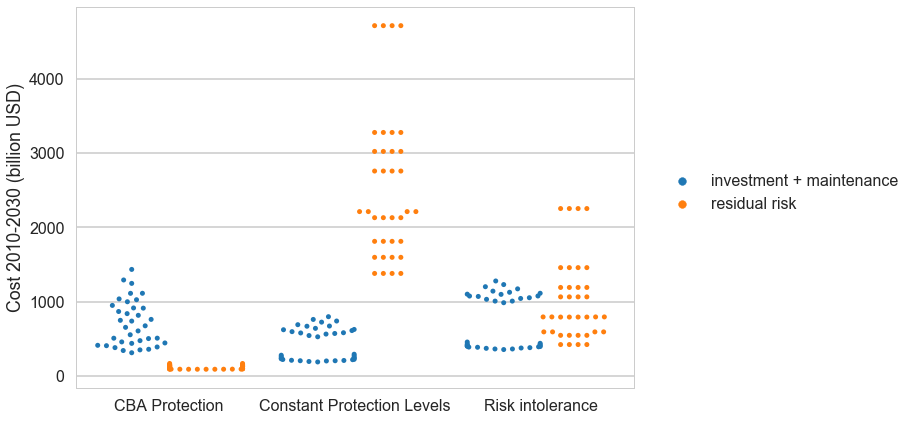

In [251]:
toplot = newdatacum[['tot_cost','seafloodcost_disc']]
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 10**(-3)*toplot.value

fig, ax = plt.subplots()
#sns.factorplot(x='ada',y='value', hue= 'costtype', data=toplot, kind="point",ax=ax, join=False, legend_out=True)
sns.swarmplot(x='ada',y='value', hue= 'costtype', data=toplot,ax=ax, dodge=True)
fig.set_size_inches(10, 7)
ax.set_xlabel("")
ax.set_ylabel("Cost 2010-2030 (billion USD)")
plt.legend(title="",bbox_to_anchor=(1.5, 0.6))

#plt.savefig("coastal_2030_3pc.png",ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_2030_3pc.pdf")

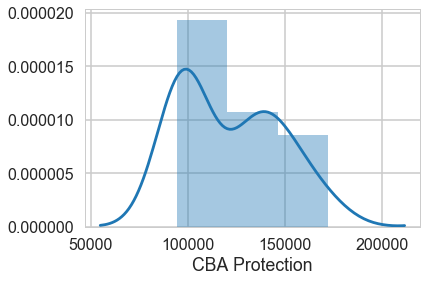

In [187]:
sns.distplot(newdatacum.seafloodcost_disc.unstack("ada")['CBA Protection'])

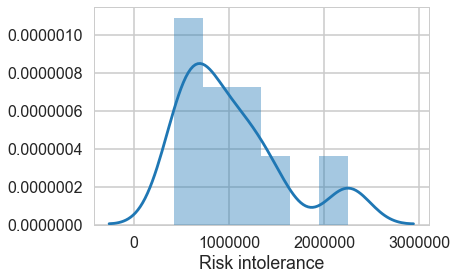

In [186]:
sns.distplot(newdatacum.seafloodcost_disc.unstack("ada")['Risk intolerance'])

In [191]:
forprim = newdatacum.seafloodcost_disc.unstack("ada")['CBA Protection'].reset_index()

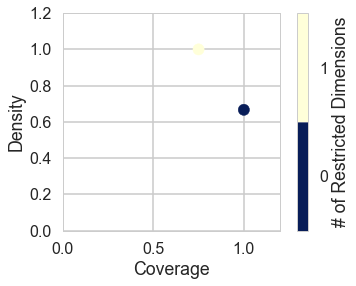

In [193]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection']], forprim['CBA Protection'],\
              threshold=100000, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [194]:
box.select(1)
print(box.coverage,box.density)
box.limits

0.75 1.0


,min,max,qp values
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},0.000677
